# Quantifying the Commons: Visualization Engineering

In this iPython Notebook, I will be laying out the basic works of pandas and visualization engineering for future efforts of project Quantifying the Commons given the current layout of data collection process from UC Berkeley, Data Science Discovery's work in Fall 2022.

## Environment and Variable Setup

First of all, here are the packages we need for pandas and visualization engineering:

In [1]:
import json
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Let us start from certifying paths towards datasets.\
For this, please make sure you have installed the newest version of dataset by performing, `git pull origin main` on your local repo.\
First, let's make sure that the CWD is located at the visualization folder.

In [2]:
CWD = os.getcwd()

From there on, let us certify the path of each .csv file.\
If your file path is different from what is used during the engineering process as listed below, please change the following values on your own.

In [3]:
path_deviantart_license_data = f"../deviantart/data_deviantart_2022_10_30.csv"
path_flickr_license_data = f"../flickr/photos.json"
path_google_license_data = f"../google_custom_search/data_google_custom_search_2022_10_31.csv"
path_google_time_data = f"../google_custom_search/data_google_custom_search_time_2022_10_31.csv"
path_google_country_data = f"../google_custom_search/data_google_custom_search_country_2022_11_3.csv"
path_ia_license_data = f"../internetarchive/data_internetarchive_2022_10_20.csv"
path_metmuseum_license_data = f"../metmuseum/data_metmuseum_2022_10_24.csv"
path_vimeo_license_data = f"../vimeo/data_vimeo_2022_10_29.csv"
path_wikicommons_license_data = f"../wikicommons/data_wikicommons_2022_10_21.csv"
path_wikipedia_license_data = f"../wikipedia/data_wikipedia_2022_10_24.csv"
path_youtube_time_data = f"../youtube/data_youtube_time_2022_10_31.csv"

Now, let us load each data path into a file. We will then engineer these datasets section by section.

In [91]:
raw_deviantart_license_data = pd.read_csv(path_deviantart_license_data)
raw_flickr_license_data = json.load(open(path_flickr_license_data))
raw_google_license_data = pd.read_csv(path_google_license_data)
raw_google_time_data = pd.read_csv(path_google_time_data)
raw_google_country_data = pd.read_csv(path_google_country_data)
raw_ia_license_data = pd.read_csv(path_ia_license_data)
raw_metmuseum_license_data = pd.read_csv(path_metmuseum_license_data)
raw_vimeo_license_data = pd.read_csv(path_vimeo_license_data)
raw_wikicommons_license_data = pd.read_csv(path_wikicommons_license_data, encoding='latin-1')
raw_wikipedia_license_data = pd.read_csv(path_wikipedia_license_data)
raw_youtube_time_data = pd.read_csv(path_youtube_time_data)

## Dataset EDA and Engineering

We will now perform small EDA and some engineering on each of the dataset, in alphabetical order platform name.

### License Type Engineering

We'll perform some basic engineering and categorization for each of the possible license typings listed in this file, using the dataset from `internetarchive`

In [5]:
license_ser = raw_ia_license_data["LICENSE TYPE"].str.lower()
license_ser.loc[len(license_ser)] = "all"
license_ser_splits_df = license_ser.str.split("/", expand=True)
license_ser_splits_df = license_ser_splits_df.rename(
    columns = {
        0: "Tool Typing",
        1: "General Typing",
        2: "Version",
        3: "Jurisdiction"
    }
)
license_ser_splits_df["Version"] = license_ser_splits_df["Version"].astype(float)
license_ser_splits_df.tail(8)

,Tool Typing,General Typing,Version,Jurisdiction
645,licenses,by-nc,4.0,None
646,licenses,by-nc-nd,4.0,None
647,licenses,by-nc-sa,4.0,None
648,licenses,by-nd,4.0,None
649,licenses,by-sa,4.0,None
650,publicdomain,mark,1.0,None
651,publicdomain,zero,1.0,None
652,all,None,NaN,None


To get further breakdown on the `General Typing` section for the above dataframe:

In [6]:
license_one_hot_encoding = pd.DataFrame()
license_one_hot_encoding["by"] = license_ser_splits_df["General Typing"].str.contains("by")
license_one_hot_encoding["sa"] = license_ser_splits_df["General Typing"].str.contains("sa")
license_one_hot_encoding["nc"] = license_ser_splits_df["General Typing"].str.contains("nc")
license_one_hot_encoding["nd"] = license_ser_splits_df["General Typing"].str.contains("nd")
license_not_six_type = license_ser_splits_df["General Typing"].str.contains("by|sa|nc|nd")
license_one_hot_encoding["neither"] = ~(license_not_six_type.fillna(False))
license_one_hot_encoding

,by,sa,nc,nd,neither
0,False,False,False,False,True
1,True,False,False,False,False
2,True,False,False,False,False
3,True,False,False,False,False
4,True,False,False,False,False
...,...,...,...,...,...
648,True,False,False,True,False
649,True,True,False,False,False
650,False,False,False,False,True
651,False,False,False,False,True


In [7]:
license_df = pd.concat([license_ser, license_ser_splits_df, license_one_hot_encoding], axis = 1)
license_df.tail(8)

,LICENSE TYPE,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
645,licenses/by-nc/4.0,licenses,by-nc,4.0,None,True,False,True,False,False
646,licenses/by-nc-nd/4.0,licenses,by-nc-nd,4.0,None,True,False,True,True,False
647,licenses/by-nc-sa/4.0,licenses,by-nc-sa,4.0,None,True,True,True,False,False
648,licenses/by-nd/4.0,licenses,by-nd,4.0,None,True,False,False,True,False
649,licenses/by-sa/4.0,licenses,by-sa,4.0,None,True,True,False,False,False
650,publicdomain/mark/1.0,publicdomain,mark,1.0,None,False,False,False,False,True
651,publicdomain/zero/1.0,publicdomain,zero,1.0,None,False,False,False,False,True
652,all,all,None,NaN,None,None,None,None,None,True


In [118]:
def merge_with_license(raw_data, withhold = False):
    if withhold:
        withhold_license_df = license_df.copy()
        withhold_license_df.loc[license_df.shape[0]] = [""] * license_df.shape[1]
        return raw_data.merge(withhold_license_df, on = "LICENSE TYPE")
    return raw_data.merge(license_df, on = "LICENSE TYPE")

### DeviantArt

The dataset looks like this

In [9]:
raw_deviantart_license_data.head(5)

,LICENSE TYPE,Document Count
0,licenses/by/1.0,88400000
1,licenses/by-nc/1.0,26400000
2,licenses/by-nc-sa/1.0,7320000
3,licenses/by-nd/1.0,102000000
4,licenses/by-nd-nc/1.0,28700000


Let's join the raw dataset with the license DataFrame from before:

In [10]:
deviantart_license_data = merge_with_license(raw_deviantart_license_data)
print(f"The shape of dataset is: {deviantart_license_data.shape}")
deviantart_license_data.head(5)

The shape of dataset is: (53, 11)


,LICENSE TYPE,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/by/1.0,88400000,licenses,by,1.0,None,True,False,False,False,False
1,licenses/by-nc/1.0,26400000,licenses,by-nc,1.0,None,True,False,True,False,False
2,licenses/by-nc-sa/1.0,7320000,licenses,by-nc-sa,1.0,None,True,True,True,False,False
3,licenses/by-nd/1.0,102000000,licenses,by-nd,1.0,None,True,False,False,True,False
4,licenses/by-nd-nc/1.0,28700000,licenses,by-nd-nc,1.0,None,True,False,True,True,False


### Flickr (photos.json)

Raw dataset looks like this:

In [11]:
flickr_json_df = pd.DataFrame(raw_flickr_license_data)
flickr_json_df

,1,2,3,4,5,6,9,10
0,"{'photos': {'page': 1, 'pages': 128, 'perpage'...","{'photos': {'page': 1, 'pages': 129, 'perpage'...","{'photos': {'page': 1, 'pages': 124, 'perpage'...","{'photos': {'page': 1, 'pages': 128, 'perpage'...","{'photos': {'page': 1, 'pages': 145, 'perpage'...","{'photos': {'page': 1, 'pages': 151, 'perpage'...","{'photos': {'page': 1, 'pages': 125, 'perpage'...","{'photos': {'page': 1, 'pages': 215, 'perpage'..."


Each item of the JSON object is shown as below:

In [12]:
pd.DataFrame(raw_flickr_license_data['1'][0])

,photos,stat
page,1,ok
pages,128,ok
perpage,500,ok
photo,"[{'id': '52404852474', 'owner': '40376653@N03'...",ok
total,64000,ok


The `photo` part of the Dataframe here is not too helpful, so we will just extract the `photos` column of each JSON object and concatenate them.

In [13]:
json_to_concat = []
for lbl in flickr_json_df.columns:
    photos_column = pd.DataFrame(raw_flickr_license_data[str(lbl)][0])['photos']
    photos_column['license id'] = str(lbl)
    photos_column = photos_column.drop(["photo", "page", "perpage", "pages"])
    json_to_concat.append(photos_column)
flickr_json_data = pd.concat(json_to_concat, axis = 1)
flickr_json_data = flickr_json_data.transpose().set_index("license id")
flickr_json_data.head(5)

,total
license id,
1,64000
2,64331
3,62000
4,64000
5,72382


We will merge the above dataset with another dataframe that indicates the license type for its corresponding license id.\
This can be retrieved either via the flickrAPI (which I am not responsible on the development for), or simply from the Example Response of this address:\
https://www.flickr.com/services/api/flickr.photos.licenses.getInfo.htm<br>
For saving time, I went with the former option.

In [14]:
flickr_license_ids = pd.read_xml(f"{CWD}/flickr_licenses.xml")
flickr_license_ids['id'] = flickr_license_ids['id'].astype(str)
flickr_license_ids = flickr_license_ids.rename(columns = {'id': 'license id'})\
    .set_index('license id')
flickr_license_ids.head(3)

,name,url
license id,,
0,All Rights Reserved,NaN
1,Attribution-NonCommercial-ShareAlike License,https://creativecommons.org/licenses/by-nc-sa/...
2,Attribution-NonCommercial License,https://creativecommons.org/licenses/by-nc/2.0/


In [15]:
flickr_license_data = flickr_json_data.merge(flickr_license_ids, left_index = True, right_index = True)
flickr_license_data["LICENSE TYPE"] = flickr_license_data["url"].str.extract(r"https://creativecommons.org/(.*)/")
flickr_license_data = merge_with_license(flickr_license_data)
flickr_license_data = flickr_license_data.iloc[:, [3, 0, 1, 2] + [i for i in range(4, len(flickr_license_data.columns))]]
flickr_license_data

,LICENSE TYPE,total,name,url,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/by-nc-sa/2.0,64000,Attribution-NonCommercial-ShareAlike License,https://creativecommons.org/licenses/by-nc-sa/...,licenses,by-nc-sa,2.0,None,True,True,True,False,False
1,licenses/by-nc/2.0,64331,Attribution-NonCommercial License,https://creativecommons.org/licenses/by-nc/2.0/,licenses,by-nc,2.0,None,True,False,True,False,False
2,licenses/by-nc-nd/2.0,62000,Attribution-NonCommercial-NoDerivs License,https://creativecommons.org/licenses/by-nc-nd/...,licenses,by-nc-nd,2.0,None,True,False,True,True,False
3,licenses/by/2.0,64000,Attribution License,https://creativecommons.org/licenses/by/2.0/,licenses,by,2.0,None,True,False,False,False,False
4,licenses/by-sa/2.0,72382,Attribution-ShareAlike License,https://creativecommons.org/licenses/by-sa/2.0/,licenses,by-sa,2.0,None,True,True,False,False,False
5,licenses/by-nd/2.0,75260,Attribution-NoDerivs License,https://creativecommons.org/licenses/by-nd/2.0/,licenses,by-nd,2.0,None,True,False,False,True,False
6,publicdomain/zero/1.0,62456,Public Domain Dedication (CC0),https://creativecommons.org/publicdomain/zero/...,publicdomain,zero,1.0,None,False,False,False,False,True
7,publicdomain/mark/1.0,107137,Public Domain Mark,https://creativecommons.org/publicdomain/mark/...,publicdomain,mark,1.0,None,False,False,False,False,True


### Google Custom Search

We will be working with all three datasets in the Google Custom Search, in the order of:\
1. General Search data
2. Time development data
3. Geographical data

#### Google General Search Data

Let's first look at the General Search data:

In [16]:
raw_google_license_data.head()

,LICENSE TYPE,No Priori,Australia,Brazil,Canada,Egypt,Germany,India,Japan,Spain,United Kingdom,United States,Arabic,Chinese (Simplified),Chinese (Traditional),English,French,Indonesian,Portuguese,Spanish
0,all,781000000,319000,1300000,582000,15900,9340000,276000,148000,293000,13100000,568000000,341000,240000,151000,681000000,1270000,331000,6680000,20100000
1,licenses/by/1.0,95200000,38400,9180,14100,415,242000,11300,18600,19800,143000,72700000,7680,20200,5010,94200000,109000,12300,33200,127000
2,licenses/by-nc/1.0,27200000,11600,3890,6370,183,76500,3350,11600,12400,52800,17100000,1880,9000,324,28900000,74200,4880,16700,31000
3,licenses/by-nc-sa/1.0,7450000,6250,1850,2910,98,28200,1530,3250,6250,25900,534000,264,4840,240,6500000,56300,1830,15100,19800
4,licenses/by-nd/1.0,102000000,40400,8420,13300,485,283000,10700,21600,21400,167000,88800000,8690,20600,3130,116000000,73300,11200,25200,114000


This dataset is basically complete and doesn't need a more interpretations, so we can just merge it with the license DataFrame above.

In [17]:
google_license_data = merge_with_license(raw_google_license_data)
google_license_data.tail()

,LICENSE TYPE,No Priori,Australia,Brazil,Canada,Egypt,Germany,India,Japan,Spain,...,Spanish,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
49,licenses/by-nc-sa/4.0,25000000,12800,6850,8400,261,66200,3810,13700,17400,...,256000,licenses,by-nc-sa,4.0,None,True,True,True,False,False
50,licenses/by-nd/4.0,299000000,122000,63700,47200,4250,995000,57200,92500,75400,...,879000,licenses,by-nd,4.0,None,True,False,False,True,False
51,licenses/by-sa/4.0,136000000,42800,15200,15300,1530,401000,18900,21000,46700,...,1460000,licenses,by-sa,4.0,None,True,True,False,False,False
52,publicdomain/mark/1.0,16600000,3190,413,1950,5,42300,485,5810,2490,...,67200,publicdomain,mark,1.0,None,False,False,False,False,True
53,publicdomain/zero/1.0,39100000,11100,2000,5340,8,121000,2610,5860,3030,...,64600,publicdomain,zero,1.0,None,False,False,False,False,True


#### Google Time Search Data

Next, let us look at the time trend dataset:

In [18]:
raw_google_time_data.head()

,LICENSE TYPE,0,6,12,18,24,30,36,42,48,...,60,66,72,78,84,90,96,102,108,114
0,all,781000000,27100000,57000000,99000000,154000000,202000000,249000000,295000000,341000000,...,387000000,430000000,467000000,504000000,482000000,499000000,517000000,519000000,582000000,525000000
1,licenses/by/1.0,82700000,209000,4140000,12300000,16000000,20500000,29800000,34200000,39500000,...,56000000,53900000,58000000,62900000,61300000,65400000,61400000,71400000,64000000,68400000
2,licenses/by-nc/1.0,27200000,59900,151000,211000,373000,397000,11300000,12900000,12700000,...,17400000,20500000,17900000,16800000,19600000,22100000,19100000,18300000,19300000,20300000
3,licenses/by-nc-sa/1.0,7450000,26900,56100,90300,121000,162000,182000,203000,224000,...,273000,258000,274000,291000,295000,301000,288000,303000,307000,308000
4,licenses/by-nd/1.0,102000000,248000,5450000,13400000,18400000,27600000,34000000,40400000,50800000,...,61200000,81000000,82700000,72100000,74400000,68500000,65800000,68300000,95400000,73100000


For the sake of analysis, it seems like we can generate a separate version that tells the general documents that appeared in between each time period.

In [19]:
raw_google_time_diff = raw_google_time_data.set_index("LICENSE TYPE").drop(["0"], axis = 1)
raw_google_time_diff = raw_google_time_diff.diff(axis = 1).drop("6", axis = 1)
raw_google_time_diff = raw_google_time_diff\
    .merge(raw_google_time_data[["6", "LICENSE TYPE"]], left_index = True, right_on = "LICENSE TYPE")\
    .set_index("LICENSE TYPE")
raw_google_time_diff.columns = raw_google_time_diff.columns.astype(int)
raw_google_time_diff = raw_google_time_diff.sort_index(axis=1)
raw_google_time_diff = raw_google_time_diff.rename(
    columns = {i: f"month {i - 6} to {i}" for i in raw_google_time_diff.columns}
)
raw_google_time_diff = raw_google_time_diff.reset_index()
raw_google_time_diff.head()


,LICENSE TYPE,month 0 to 6,month 6 to 12,month 12 to 18,month 18 to 24,month 24 to 30,month 30 to 36,month 36 to 42,month 42 to 48,month 48 to 54,month 54 to 60,month 60 to 66,month 66 to 72,month 72 to 78,month 78 to 84,month 84 to 90,month 90 to 96,month 96 to 102,month 102 to 108,month 108 to 114
0,all,27100000,29900000,42000000,55000000,48000000,47000000,46000000,46000000,21000000,25000000,43000000,37000000,37000000,-22000000,17000000,18000000,2000000,63000000,-57000000
1,licenses/by/1.0,209000,3931000,8160000,3700000,4500000,9300000,4400000,5300000,8500000,8000000,-2100000,4100000,4900000,-1600000,4100000,-4000000,10000000,-7400000,4400000
2,licenses/by-nc/1.0,59900,91100,60000,162000,24000,10903000,1600000,-200000,1900000,2800000,3100000,-2600000,-1100000,2800000,2500000,-3000000,-800000,1000000,1000000
3,licenses/by-nc-sa/1.0,26900,29200,34200,30700,41000,20000,21000,21000,20000,29000,-15000,16000,17000,4000,6000,-13000,15000,4000,1000
4,licenses/by-nd/1.0,248000,5202000,7950000,5000000,9200000,6400000,6400000,10400000,1200000,9200000,19800000,1700000,-10600000,2300000,-5900000,-2700000,2500000,27100000,-22300000


In [20]:
google_time_data = merge_with_license(raw_google_time_data)
google_time_diff = merge_with_license(raw_google_time_diff)

#### Google Geographical Search Data

Last but not least, let's deal with the geographical data:

In [21]:
raw_google_country_data_transpose = raw_google_country_data.transpose()
raw_google_country_data_transpose.columns = raw_google_country_data_transpose.iloc[0]
raw_google_country_data_transpose = raw_google_country_data_transpose.iloc[1:, :]
raw_google_country_data_transpose = raw_google_country_data_transpose.rename(
    columns = {
        "all": "All Licensed Documents"
    }
)
raw_google_country_data_transpose.index.names = ["Country"]
raw_google_country_data_transpose.head()

LICENSE TYPE,All Licensed Documents,All Documents
Country,,
Afghanistan,728,446000
Albania,992,949000
Algeria,1870,1330000
American Samoa,2,551
Andorra,5,101000


To align it with the standards of `geopandas`, let's work on fetching the country codes from:\
https://github.com/lukes/ISO-3166-Countries-with-Regional-Codes/blob/master/all/all.csv

In [22]:
country_codes_data = pd.read_csv("./country_alpha3.csv")
country_codes_data.head()

,name,alpha-2,alpha-3,country-code,iso_3166-2,region,sub-region,intermediate-region,region-code,sub-region-code,intermediate-region-code
0,Afghanistan,AF,AFG,4,ISO 3166-2:AF,Asia,Southern Asia,NaN,142.0,34.0,NaN
1,Åland Islands,AX,ALA,248,ISO 3166-2:AX,Europe,Northern Europe,NaN,150.0,154.0,NaN
2,Albania,AL,ALB,8,ISO 3166-2:AL,Europe,Southern Europe,NaN,150.0,39.0,NaN
3,Algeria,DZ,DZA,12,ISO 3166-2:DZ,Africa,Northern Africa,NaN,2.0,15.0,NaN
4,American Samoa,AS,ASM,16,ISO 3166-2:AS,Oceania,Polynesia,NaN,9.0,61.0,NaN


In [23]:
country_codes = []
google_country_data = raw_google_country_data_transpose.copy()
google_country_data.rename(
    index = {
        "Bolivia": "Bolivia (Plurinational State of)",
        "Cape Verde": "Cabo Verde",
        "Congo  the Democratic Republic of the": "Congo, Democratic Republic of the",
        "Cote D'ivoire": "Côte d'Ivoire",
        "Croatia (Hrvatska)": "Croatia",
        "Czech Republic": "Czechia",
        "East Timor": "Timor-Leste",
        "Heard Island and Mcdonald Islands": "Heard Island and McDonald Islands",
        "Holy See (Vatican City State)": "Holy See",
        "Iran  Islamic Republic of": "Iran (Islamic Republic of)",
        "Korea  Democratic People's Republic of": "Korea (Democratic People's Republic of)",
        "Korea  Republic of": "Korea, Republic of",
        "Libyan Arab Jamahiriya": "Libya",
        "Macedonia  the Former Yugosalv Republic of": "North Macedonia",
        "Micronesia  Federated States of": "Micronesia (Federated States of)",
        "Moldova  Republic of": "Moldova, Republic of",
        "Netherlands Antilles": "Netherlands",
        "Palestinian Territory": "Palestine, State of",
        "Reunion": "Réunion",
        "Saint Helena": "Saint Helena, Ascension and Tristan da Cunha",
        "Serbia and Montenegro": "Serbia",
        "Swaziland": "Eswatini",
        "Taiwan  Province of China": "Taiwan, Province of China",
        "Tanzania  United Republic of": "Tanzania, United Republic of",
        "United Kingdom": "United Kingdom of Great Britain and Northern Ireland",
        "United States": "United States of America",
        "Venezuela": "Venezuela (Bolivarian Republic of)",
        "Vietnam": "Viet Nam",
        "Virgin Islands  British": "Virgin Islands (British)",
        "Virgin Islands  U.S.": "Virgin Islands (U.S.)"
    },
    inplace = True
)
for country in google_country_data.index:
    if country in country_codes_data["name"].values:
        cur_country_code = country_codes_data\
            [country_codes_data["name"] == country]["alpha-3"].iloc[0]
        country_codes.append(cur_country_code)
    else:
        country_codes.append(None)
google_country_data['CODE'] = country_codes
google_country_data = google_country_data.dropna()
google_country_data

LICENSE TYPE,All Licensed Documents,All Documents,CODE
Country,,,
Afghanistan,728,446000,AFG
Albania,992,949000,ALB
Algeria,1870,1330000,DZA
American Samoa,2,551,ASM
Andorra,5,101000,AND
...,...,...,...
Wallis and Futuna,2,405,WLF
Western Sahara,0,15,ESH
Yemen,32,328000,YEM


### Internetarchive

Here's how the raw dataset looks:

In [24]:
raw_ia_license_data

,LICENSE TYPE,Document Count
0,licenses/publicdomain,163
1,licenses/by/1.0,40
2,licenses/by/1.0/fi,0
3,licenses/by/1.0/il,0
4,licenses/by/1.0/nl,0
...,...,...
647,licenses/by-nc-sa/4.0,5237
648,licenses/by-nd/4.0,0
649,licenses/by-sa/4.0,21
650,publicdomain/mark/1.0,0


A simple merging with the license DataFrame should work!

In [26]:
ia_license_data = merge_with_license(raw_ia_license_data)
ia_license_data

,LICENSE TYPE,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/publicdomain,163,licenses,publicdomain,NaN,None,False,False,False,False,True
1,licenses/by/1.0,40,licenses,by,1.0,None,True,False,False,False,False
2,licenses/by/1.0/fi,0,licenses,by,1.0,fi,True,False,False,False,False
3,licenses/by/1.0/il,0,licenses,by,1.0,il,True,False,False,False,False
4,licenses/by/1.0/nl,0,licenses,by,1.0,nl,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...
647,licenses/by-nc-sa/4.0,5237,licenses,by-nc-sa,4.0,None,True,True,True,False,False
648,licenses/by-nd/4.0,0,licenses,by-nd,4.0,None,True,False,False,True,False
649,licenses/by-sa/4.0,21,licenses,by-sa,4.0,None,True,True,False,False,False
650,publicdomain/mark/1.0,0,publicdomain,mark,1.0,None,False,False,False,False,True


### MetMuseum

Trivial case since it is a simple json drop:

In [28]:
metmuseum_license_data = merge_with_license(raw_metmuseum_license_data)
metmuseum_license_data

,LICENSE TYPE,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,publicdomain/zero/1.0,482469,publicdomain,zero,1.0,None,False,False,False,False,True


### Vimeo

Here is how the dataset looks:

In [29]:
raw_vimeo_license_data

,LICENSE TYPE,Document Count
0,CC,9702757
1,CC-BY,2294755
2,CC-BY-NC,1574863
3,CC-BY-NC-ND,2811800
4,CC-BY-NC-SA,765531
5,CC-BY-ND,1331168
6,CC-BY-SA,735782
7,CC0,188868


Let us rename the values under `"LICENSE TYPE"` to get an easier merge with license DataFrame.\
According to this [page](https://vimeo.com/creativecommons?_gl=1*gg5b1q*_ga*NzE5NTI4MzQzLjE2Njc1NDA0MDg.*_ga_126VYLCXDY*MTY2NzU0MDQwOC4xLjAuMTY2NzU0MDQwOC42MC4wLjA), we may also find the every non public domain license has version 3.0, and public domain license is same as that of metmuseum.\
Therefore, the engineering would like what follows:

In [33]:
vimeo_license_data_renamed = raw_vimeo_license_data.copy()
vimeo_license_data_renamed["LICENSE TYPE"] = vimeo_license_data_renamed["LICENSE TYPE"].str.lower()
vimeo_license_data_renamed["LICENSE TYPE"] = [
    "all",
    "licenses/by/3.0",
    "licenses/by-nc/3.0",
    "licenses/by-nc-nd/3.0",
    "licenses/by-nc-sa/3.0",
    "licenses/by-nd/3.0",
    "licenses/by-sa/3.0",
    "publicdomain/zero/1.0"
]
vimeo_license_data_renamed

,LICENSE TYPE,Document Count
0,all,9702757
1,licenses/by/3.0,2294755
2,licenses/by-nc/3.0,1574863
3,licenses/by-nc-nd/3.0,2811800
4,licenses/by-nc-sa/3.0,765531
5,licenses/by-nd/3.0,1331168
6,licenses/by-sa/3.0,735782
7,publicdomain/zero/1.0,188868


In [34]:
vimeo_license_data = merge_with_license(vimeo_license_data_renamed)
vimeo_license_data

,LICENSE TYPE,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,all,9702757,all,None,NaN,None,None,None,None,None,True
1,licenses/by/3.0,2294755,licenses,by,3.0,None,True,False,False,False,False
2,licenses/by-nc/3.0,1574863,licenses,by-nc,3.0,None,True,False,True,False,False
3,licenses/by-nc-nd/3.0,2811800,licenses,by-nc-nd,3.0,None,True,False,True,True,False
4,licenses/by-nc-sa/3.0,765531,licenses,by-nc-sa,3.0,None,True,True,True,False,False
5,licenses/by-nd/3.0,1331168,licenses,by-nd,3.0,None,True,False,False,True,False
6,licenses/by-sa/3.0,735782,licenses,by-sa,3.0,None,True,True,False,False,False
7,publicdomain/zero/1.0,188868,publicdomain,zero,1.0,None,False,False,False,False,True


### Wikicommons

Let's look at this dataset. It is a tricky one to work with:

In [92]:
raw_wikicommons_license_data

,LICENSE TYPE,File Count,Page Count
0,Free_Creative_Commons_licenses,0,0
1,Free_Creative_Commons_licenses/CC-BY,1,0
2,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0,7722,0
3,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0...,7722,0
4,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0...,93,0
...,...,...,...
140,Free_Creative_Commons_licenses/CC-Zero/Images ...,39,0
141,Free_Creative_Commons_licenses/CC-Zero/Images ...,360,0
142,Free_Creative_Commons_licenses/CC-Zero/Images ...,202,0
143,Free_Creative_Commons_licenses/CC-Zero/Images ...,215,0


In [130]:
raw_wikicommons_license_types = raw_wikicommons_license_data["LICENSE TYPE"]\
    .str.lower()\
    .str.split("/", expand=True)
raw_wikicommons_license_types = raw_wikicommons_license_types.iloc[:, [0, 1, 2]]
raw_wikicommons_license_types[1] = raw_wikicommons_license_types[1]\
    .str.extract(r"cc-(.*)")
raw_wikicommons_license_types.loc[~raw_wikicommons_license_types[1].isna(), 1] = \
    raw_wikicommons_license_types.loc[~raw_wikicommons_license_types[1].isna(), 1]\
        .map(lambda s: f"licenses/{s}")
raw_wikicommons_license_types[2] = raw_wikicommons_license_types[2]\
    .str.extract(r".*-(\d\.\d)")
raw_wikicommons_license_types[2] = raw_wikicommons_license_types[1] + "/" + raw_wikicommons_license_types[2]
raw_wikicommons_license_types.loc[raw_wikicommons_license_types[1] == "licenses/zero", 2] = \
    raw_wikicommons_license_types.loc[raw_wikicommons_license_types[1] == "licenses/zero", 2]\
        .map(lambda x: "publicdomain/zero/1.0")
raw_wikicommons_license_types = raw_wikicommons_license_types.drop([0, 1], axis=1)\
    .rename(
        columns = {
            2: "LICENSE TYPE"
        }
    )
raw_wikicommons_license_types

,LICENSE TYPE
0,NaN
1,NaN
2,licenses/by/1.0
3,licenses/by/1.0
4,licenses/by/1.0
...,...
140,publicdomain/zero/1.0
141,publicdomain/zero/1.0
142,publicdomain/zero/1.0
143,publicdomain/zero/1.0


In [135]:
raw_wikicommons_license_data_renamed = raw_wikicommons_license_data.rename(columns = {"LICENSE TYPE": "LICENSE DESCRIPTION"})
wikicommons_license_merge_data = pd.concat([raw_wikicommons_license_data_renamed, raw_wikicommons_license_types], axis = 1)
wikicommons_license_merge_data.head()

,LICENSE DESCRIPTION,File Count,Page Count,LICENSE TYPE
0,Free_Creative_Commons_licenses,0,0,NaN
1,Free_Creative_Commons_licenses/CC-BY,1,0,NaN
2,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0,7722,0,licenses/by/1.0
3,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0...,7722,0,licenses/by/1.0
4,Free_Creative_Commons_licenses/CC-BY/CC-BY-1.0...,93,0,licenses/by/1.0


In [140]:
wikicommons_license_merge_data_modified = wikicommons_license_merge_data.fillna("")
wikicommons_license_merge_data_modified["LICENSE DESCRIPTION"] = \
    wikicommons_license_merge_data_modified["LICENSE DESCRIPTION"].str\
        .extract(r"Free_Creative_Commons_licenses/(.*)")
wikicommons_license_data = merge_with_license(
    wikicommons_license_merge_data_modified,
    withhold = True
)
wikicommons_license_data[5:10]

,LICENSE DESCRIPTION,File Count,Page Count,LICENSE TYPE,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
5,CC-PD/LibriVox - The Federalist Papers,85,0,,,,,,,,,,
6,CC-SA-1.0,4446,0,,,,,,,,,,
7,CC-BY/CC-BY-1.0,7722,0,licenses/by/1.0,licenses,by,1.0,None,True,False,False,False,False
8,CC-BY/CC-BY-1.0/CC-BY-1.0+,7722,0,licenses/by/1.0,licenses,by,1.0,None,True,False,False,False,False
9,CC-BY/CC-BY-1.0/CC-BY-1.0+/CC-BY-1.0-FI,93,0,licenses/by/1.0,licenses,by,1.0,None,True,False,False,False,False


### Wikipedia

Let us look at the dataset first:

In [141]:
raw_wikipedia_license_data

,pages,articles,edits,images,users,activeusers,admins,jobs,cirrussearch-article-words,queued-massmessages,language
0,509,0,4685,0,4063,0,1,0,0,0,aa
1,20546,6021,119663,9,18033,19,2,0,229249,0,ab
2,374163,105074,2526966,9626,154785,162,16,0,36462286,0,af
3,2449,592,29394,0,12737,11,1,0,164425,0,ak
4,45950,15042,372281,1766,40163,56,2,0,1768160,0,am
...,...,...,...,...,...,...,...,...,...,...,...
174,44269,15403,580327,1062,46110,46,3,0,3428277,0,yi
175,55592,31878,556674,166,25338,66,3,0,2378058,0,yo
176,4164,2030,39408,0,9857,13,1,0,112245,0,za
177,7188090,1313317,73931414,61441,3275098,8147,66,0,618123370,0,zh


To engineer this, let's also use another file from the wikipedia branch that entails the relationship betwen language code and its name:

In [158]:
wiki_lang_codes = pd.read_csv("../wikipedia/language-codes_csv.csv")
raw_wikipedia_license_lang_data = raw_wikipedia_license_data.merge(wiki_lang_codes, left_on = "language", right_on = "alpha2")
raw_wikipedia_license_lang_data = raw_wikipedia_license_lang_data.drop("language", axis = 1)
reordered_ind = ["LICENSE TYPE"] + [c for c in raw_wikipedia_license_lang_data.columns]
raw_wikipedia_license_lang_data["LICENSE TYPE"] = pd.Series(["licenses/by-sa/3.0"] * raw_wikipedia_license_lang_data.shape[0])
raw_wikipedia_license_lang_data = raw_wikipedia_license_lang_data[reordered_ind]
raw_wikipedia_license_lang_data.head()

,LICENSE TYPE,pages,articles,edits,images,users,activeusers,admins,jobs,cirrussearch-article-words,queued-massmessages,alpha2,English
0,licenses/by-sa/3.0,509,0,4685,0,4063,0,1,0,0,0,aa,Afar
1,licenses/by-sa/3.0,20546,6021,119663,9,18033,19,2,0,229249,0,ab,Abkhazian
2,licenses/by-sa/3.0,374163,105074,2526966,9626,154785,162,16,0,36462286,0,af,Afrikaans
3,licenses/by-sa/3.0,2449,592,29394,0,12737,11,1,0,164425,0,ak,Akan
4,licenses/by-sa/3.0,45950,15042,372281,1766,40163,56,2,0,1768160,0,am,Amharic


In [159]:
wikipedia_license_lang_data = merge_with_license(raw_wikipedia_license_lang_data)
wikipedia_license_lang_data.head()

,LICENSE TYPE,pages,articles,edits,images,users,activeusers,admins,jobs,cirrussearch-article-words,...,English,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/by-sa/3.0,509,0,4685,0,4063,0,1,0,0,...,Afar,licenses,by-sa,3.0,None,True,True,False,False,False
1,licenses/by-sa/3.0,20546,6021,119663,9,18033,19,2,0,229249,...,Abkhazian,licenses,by-sa,3.0,None,True,True,False,False,False
2,licenses/by-sa/3.0,374163,105074,2526966,9626,154785,162,16,0,36462286,...,Afrikaans,licenses,by-sa,3.0,None,True,True,False,False,False
3,licenses/by-sa/3.0,2449,592,29394,0,12737,11,1,0,164425,...,Akan,licenses,by-sa,3.0,None,True,True,False,False,False
4,licenses/by-sa/3.0,45950,15042,372281,1766,40163,56,2,0,1768160,...,Amharic,licenses,by-sa,3.0,None,True,True,False,False,False


### YouTube

For YouTube, here is the dataset we concern:

In [162]:
raw_youtube_time_data.head()

,LICENSE TYPE,Time,Document Count
0,licenses/by/3.0,2009-1,57964
1,licenses/by/3.0,2009-3,39066
2,licenses/by/3.0,2009-5,73928
3,licenses/by/3.0,2009-7,51207
4,licenses/by/3.0,2009-9,85426


However, the last values of `raw_youtube_time_data` are all capped with the value `1000000`.\
We can make an imputed version of this data using some tools, but before that, let's try to see how YouTube's time data look like in trend and curve shape:

<AxesSubplot:xlabel='time coord', ylabel='Document Count'>

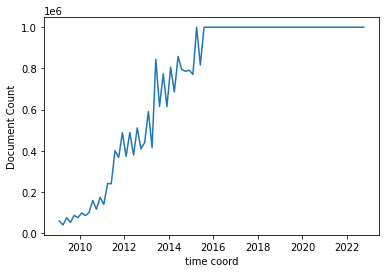

In [193]:
raw_youtube_time_data_toplot = raw_youtube_time_data.copy()
raw_youtube_time_data_toplot["Year"] = raw_youtube_time_data_toplot["Time"].str.extract("(\d+)-\d+").astype(int)
raw_youtube_time_data_toplot["Month"] = raw_youtube_time_data_toplot["Time"].str.extract("\d+-(\d+)").astype(int)
raw_youtube_time_data_toplot["time coord"] = raw_youtube_time_data_toplot["Year"] + raw_youtube_time_data_toplot["Month"] / 12
sns.lineplot(data = raw_youtube_time_data_toplot, x = "time coord", y = "Document Count")

Let's try CubicSpline for imputing the rest of the values:

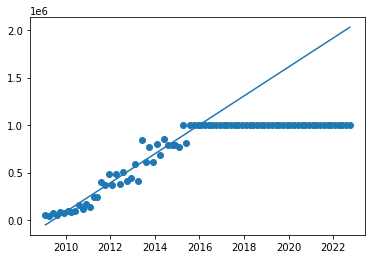

In [194]:
import sklearn.linear_model as lm
model = lm.LinearRegression()
index_limiter = raw_youtube_time_data_toplot["time coord"] < 2016
model.fit(
    X = raw_youtube_time_data_toplot[index_limiter][["time coord"]],
    y = raw_youtube_time_data_toplot[index_limiter]["Document Count"]
)
plt.plot(raw_youtube_time_data_toplot["time coord"], model.predict(raw_youtube_time_data_toplot[["time coord"]]))
plt.scatter(data = raw_youtube_time_data_toplot, x = "time coord", y = "Document Count")

In [198]:
youtube_time_linear_imputed = raw_youtube_time_data.copy()
index_limiter = raw_youtube_time_data_toplot["time coord"] > 2016
youtube_time_linear_imputed.loc[index_limiter, "Document Count"] = model.predict(raw_youtube_time_data_toplot[index_limiter][["time coord"]])
youtube_time_linear_imputed

,LICENSE TYPE,Time,Document Count
0,licenses/by/3.0,2009-1,5.796400e+04
1,licenses/by/3.0,2009-3,3.906600e+04
2,licenses/by/3.0,2009-5,7.392800e+04
3,licenses/by/3.0,2009-7,5.120700e+04
4,licenses/by/3.0,2009-9,8.542600e+04
...,...,...,...
78,licenses/by/3.0,2022-1,1.927027e+06
79,licenses/by/3.0,2022-3,1.952366e+06
80,licenses/by/3.0,2022-5,1.977705e+06
81,licenses/by/3.0,2022-7,2.003044e+06


In [201]:
youtube_time_licensed = merge_with_license(raw_youtube_time_data)
youtube_time_licensed

,LICENSE TYPE,Time,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/by/3.0,2009-1,57964,licenses,by,3.0,None,True,False,False,False,False
1,licenses/by/3.0,2009-3,39066,licenses,by,3.0,None,True,False,False,False,False
2,licenses/by/3.0,2009-5,73928,licenses,by,3.0,None,True,False,False,False,False
3,licenses/by/3.0,2009-7,51207,licenses,by,3.0,None,True,False,False,False,False
4,licenses/by/3.0,2009-9,85426,licenses,by,3.0,None,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
78,licenses/by/3.0,2022-1,1000000,licenses,by,3.0,None,True,False,False,False,False
79,licenses/by/3.0,2022-3,1000000,licenses,by,3.0,None,True,False,False,False,False
80,licenses/by/3.0,2022-5,1000000,licenses,by,3.0,None,True,False,False,False,False
81,licenses/by/3.0,2022-7,1000000,licenses,by,3.0,None,True,False,False,False,False


In [202]:
youtube_time_licensed_linear_imputed = merge_with_license(youtube_time_linear_imputed)
youtube_time_licensed_linear_imputed

,LICENSE TYPE,Time,Document Count,Tool Typing,General Typing,Version,Jurisdiction,by,sa,nc,nd,neither
0,licenses/by/3.0,2009-1,5.796400e+04,licenses,by,3.0,None,True,False,False,False,False
1,licenses/by/3.0,2009-3,3.906600e+04,licenses,by,3.0,None,True,False,False,False,False
2,licenses/by/3.0,2009-5,7.392800e+04,licenses,by,3.0,None,True,False,False,False,False
3,licenses/by/3.0,2009-7,5.120700e+04,licenses,by,3.0,None,True,False,False,False,False
4,licenses/by/3.0,2009-9,8.542600e+04,licenses,by,3.0,None,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
78,licenses/by/3.0,2022-1,1.927027e+06,licenses,by,3.0,None,True,False,False,False,False
79,licenses/by/3.0,2022-3,1.952366e+06,licenses,by,3.0,None,True,False,False,False,False
80,licenses/by/3.0,2022-5,1.977705e+06,licenses,by,3.0,None,True,False,False,False,False
81,licenses/by/3.0,2022-7,2.003044e+06,licenses,by,3.0,None,True,False,False,False,False
